In [1]:
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from scipy.ndimage import median_filter
import statsmodels.tsa.stattools as stattools
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

MIN_WINDOW_SEC = 2  

def extract_features(xyz, sample_rate=100):
    '''Extract commonly used HAR time-series features. xyz is a window of shape (N,3)'''
    
    if np.isnan(xyz).any():
        return {}
    
    if len(xyz) <= MIN_WINDOW_SEC * sample_rate:
        return {}
    
    feats = {}
    
    v = np.linalg.norm(xyz, axis=1)
    v = median_filter(v, size=5, mode='nearest')
    v = v - 1  # detrend: "remove gravity"
    v = np.clip(v, -2, 2)  # clip abnormaly high values
    
    # Moments features
    feats.update(moments_features(v, sample_rate))
    
    # Quantile features
    feats.update(quantile_features(v, sample_rate))
    
    # Autocorrelation features
    feats.update(autocorr_features(v, sample_rate))
    
    # Spectral features
    feats.update(spectral_features(v, sample_rate))
    
    # FFT features
    feats.update(fft_features(v, sample_rate))
    
    # Peak features
    feats.update(peaks_features(v, sample_rate))
    
    return feats


def moments_features(v, sample_rate=None):
    """Moments"""
    avg = np.mean(v)
    std = np.std(v)
    if std > .01:
        skew = np.nan_to_num(stats.skew(v))
        kurt = np.nan_to_num(stats.kurtosis(v))
    else:
        skew = kurt = 0
    feats = {
        'avg': avg,
        'std': std,
        'skew': skew,
        'kurt': kurt,
    }
    return feats


def quantile_features(v, sample_rate=None):
    """Quantiles (min, 25th, med, 75th, max)"""
    feats = {}
    feats['min'], feats['q25'], feats['med'], feats['q75'], feats['max'] = np.quantile(v, (0, .25, .5, .75, 1))
    return feats


def autocorr_features(v, sample_rate):
    """Autocorrelation features"""
    
    with np.errstate(divide='ignore', invalid='ignore'):  # ignore invalid div warnings
        u = np.nan_to_num(stattools.acf(v, nlags=2 * sample_rate))
    
    peaks, _ = signal.find_peaks(u, prominence=.1)
    if len(peaks) > 0:
        acf_1st_max_loc = peaks[0]
        acf_1st_max = u[acf_1st_max_loc]
        acf_1st_max_loc /= sample_rate  # in secs
    else:
        acf_1st_max = acf_1st_max_loc = 0.0
    
    valleys, _ = signal.find_peaks(-u, prominence=.1)
    if len(valleys) > 0:
        acf_1st_min_loc = valleys[0]
        acf_1st_min = u[acf_1st_min_loc]
        acf_1st_min_loc /= sample_rate  # in secs
    else:
        acf_1st_min = acf_1st_min_loc = 0.0
    
    acf_zeros = np.sum(np.diff(np.signbit(u)))
    
    feats = {
        'acf_1st_max': acf_1st_max,
        'acf_1st_max_loc': acf_1st_max_loc,
        'acf_1st_min': acf_1st_min,
        'acf_1st_min_loc': acf_1st_min_loc,
        'acf_zeros': acf_zeros,
    }
    
    return feats


def spectral_features(v, sample_rate):
    """Spectral entropy, average power, dominant frequencies"""
    
    feats = {}
    
    freqs, powers = signal.periodogram(v, fs=sample_rate, detrend='constant', scaling='density')
    powers /= (len(v) / sample_rate)    # unit/sec
    
    feats['pentropy'] = stats.entropy(powers[powers > 0])
    feats['power'] = np.sum(powers)
    
    peaks, _ = signal.find_peaks(powers)
    peak_powers = powers[peaks]
    peak_freqs = freqs[peaks]
    peak_ranks = np.argsort(peak_powers)[::-1]
    
    TOPN = 3
    feats.update({f"f{i + 1}": 0 for i in range(TOPN)})
    feats.update({f"p{i + 1}": 0 for i in range(TOPN)})
    for i, j in enumerate(peak_ranks[:TOPN]):
        feats[f"f{i + 1}"] = peak_freqs[j]
        feats[f"p{i + 1}"] = peak_powers[j]
    
    return feats


def fft_features(v, sample_rate, nfreqs=5):
    """Power of frequencies 0Hz, 1Hz, 2Hz, ... using Welch's method"""
    
    _, powers = signal.welch(
        v, fs=sample_rate,
        nperseg=sample_rate,
        noverlap=sample_rate // 2,
        detrend='constant',
        scaling='density',
        average='median'
    )
    
    feats = {f"fft{i}": powers[i] for i in range(nfreqs + 1)}
    
    return feats


def peaks_features(v, sample_rate):
    """Features of the signal peaks"""
    
    feats = {}
    u = butterfilt(v, 5, fs=sample_rate)  # lowpass 5Hz
    peaks, peak_props = signal.find_peaks(u, distance=0.2 * sample_rate, prominence=0.25)
    feats['npeaks'] = len(peaks) / (len(v) / sample_rate)  # peaks/sec
    if len(peak_props['prominences']) > 0:
        feats['peaks_avg_promin'] = np.mean(peak_props['prominences'])
        feats['peaks_min_promin'] = np.min(peak_props['prominences'])
        feats['peaks_max_promin'] = np.max(peak_props['prominences'])
    else:
        feats['peaks_avg_promin'] = feats['peaks_min_promin'] = feats['peaks_max_promin'] = 0
    
    return feats


def butterfilt(x, cutoffs, fs, order=4, axis=0):
    """Butterworth filter"""
    nyq = 0.5 * fs
    if isinstance(cutoffs, tuple):
        hicut, lowcut = cutoffs
        if hicut > 0:
            btype = 'bandpass'
            Wn = (hicut / nyq, lowcut / nyq)
        else:
            btype = 'low'
            Wn = lowcut / nyq
    else:
        btype = 'low'
        Wn = cutoffs / nyq
    sos = signal.butter(order, Wn, btype=btype, analog=False, output='sos')
    y = signal.sosfiltfilt(sos, x, axis=axis)
    return y


def get_feature_names():
    """Get the list of feature names in consistent order"""
    # Create a dummy window to extract feature names
    dummy_window = np.random.randn(500, 3) * 0.1
    feats = extract_features(dummy_window, 100)
    return list(feats.keys())


def extract_features_batch(X, sample_rate=100, batch_size=1000):
    """
    Extract features from all windows in X
    
    Parameters:
    -----------
    X : numpy array of shape (n_samples, n_timesteps, 3)
        The input accelerometer data
    sample_rate : int
        Sampling rate in Hz (default 100)
    batch_size : int
        Number of windows to process at once for progress updates
    
    Returns:
    --------
    X_features : numpy array of shape (n_samples, 32)
        Extracted features for all windows
    feature_names : list
        Names of the features in order
    """
    
    n_samples = X.shape[0]
    
    # Get feature names from a dummy extraction
    feature_names = get_feature_names()
    n_features = len(feature_names)
    
    print(f"Extracting {n_features} features from {n_samples} windows...")
    print(f"Features: {feature_names}")
    
    # Initialize feature matrix
    X_features = np.zeros((n_samples, n_features), dtype=np.float32)
    
    # Track failed extractions
    failed_indices = []
    
    # Process in batches for progress tracking
    for batch_start in tqdm(range(0, n_samples, batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, n_samples)
        
        for i in range(batch_start, batch_end):
            try:
                # Extract features for this window
                features = extract_features(X[i], sample_rate)
                
                if features:  # If extraction was successful
                    # Fill in the feature values in consistent order
                    for j, feat_name in enumerate(feature_names):
                        X_features[i, j] = features.get(feat_name, 0.0)
                else:
                    # Mark as failed extraction
                    failed_indices.append(i)
                    
            except Exception as e:
                print(f"\nError processing window {i}: {e}")
                failed_indices.append(i)
    
    if failed_indices:
        print(f"\nWarning: {len(failed_indices)} windows failed feature extraction")
        print(f"Failed indices: {failed_indices[:10]}..." if len(failed_indices) > 10 else f"Failed indices: {failed_indices}")
    
    print(f"\nFeature extraction complete!")
    print(f"Output shape: {X_features.shape}")
    print(f"Features extracted: {feature_names}")
    
    # Basic statistics
    print(f"\nFeature statistics:")
    print(f"  Min values: {np.min(X_features, axis=0)[:5]}...")
    print(f"  Max values: {np.max(X_features, axis=0)[:5]}...")
    print(f"  Mean values: {np.mean(X_features, axis=0)[:5]}...")
    print(f"  NaN count: {np.isnan(X_features).sum()}")
    print(f"  Inf count: {np.isinf(X_features).sum()}")
    
    return X_features, feature_names


def load_prepared_data(data_dir='preprocessed', schema='WillettsSpecific2018'):
    """Load preprocessed data"""
    print(f"Loading prepared data from: {data_dir}")
    
    X = np.load(os.path.join(data_dir, 'X.npy'))
    Y = np.load(os.path.join(data_dir, f'Y_{schema}.npy'), allow_pickle=True)
    T = np.load(os.path.join(data_dir, 'T.npy'), allow_pickle=True)
    P = np.load(os.path.join(data_dir, 'P.npy'), allow_pickle=True)
    
    print(f"\nLoaded data:")
    print(f"  X shape: {X.shape}")
    print(f"  Y shape: {Y.shape}")
    print(f"  Number of participants: {len(np.unique(P))}")
    
    return X, Y, T, P


def save_features(X_features, feature_names, save_dir='preprocessed'):
    """Save extracted features and feature names"""
    
    # Create directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Save features
    features_path = os.path.join(save_dir, 'X_features.npy')
    np.save(features_path, X_features)
    print(f"\nSaved features to: {features_path}")
    
    # Save feature names
    names_path = os.path.join(save_dir, 'feature_names.npy')
    np.save(names_path, np.array(feature_names))
    print(f"Saved feature names to: {names_path}")
    
    return features_path, names_path


# Main execution
if __name__ == "__main__":
    
    # Load data
    X, Y, T, P = load_prepared_data(schema='WillettsSpecific2018')
    
    # Extract features from all windows
    # Assuming 100Hz sample rate (1000 timesteps = 10 seconds at 100Hz)
    X_features, feature_names = extract_features_batch(X, sample_rate=100, batch_size=1000)
    
    # Save the features
    save_features(X_features, feature_names)
    
    print("\n" + "="*50)
    print("Feature extraction completed successfully!")
    print(f"Original data shape: {X.shape}")
    print(f"Feature matrix shape: {X_features.shape}")
    print("="*50)

Loading prepared data from: preprocessed

Loaded data:
  X shape: (1398022, 1000, 3)
  Y shape: (1398022,)
  Number of participants: 151
Extracting 32 features from 1398022 windows...
Features: ['avg', 'std', 'skew', 'kurt', 'min', 'q25', 'med', 'q75', 'max', 'acf_1st_max', 'acf_1st_max_loc', 'acf_1st_min', 'acf_1st_min_loc', 'acf_zeros', 'pentropy', 'power', 'f1', 'f2', 'f3', 'p1', 'p2', 'p3', 'fft0', 'fft1', 'fft2', 'fft3', 'fft4', 'fft5', 'npeaks', 'peaks_avg_promin', 'peaks_min_promin', 'peaks_max_promin']


Processing batches: 100%|██████████| 1399/1399 [29:34<00:00,  1.27s/it]



Feature extraction complete!
Output shape: (1398022, 32)
Features extracted: ['avg', 'std', 'skew', 'kurt', 'min', 'q25', 'med', 'q75', 'max', 'acf_1st_max', 'acf_1st_max_loc', 'acf_1st_min', 'acf_1st_min_loc', 'acf_zeros', 'pentropy', 'power', 'f1', 'f2', 'f3', 'p1', 'p2', 'p3', 'fft0', 'fft1', 'fft2', 'fft3', 'fft4', 'fft5', 'npeaks', 'peaks_avg_promin', 'peaks_min_promin', 'peaks_max_promin']

Feature statistics:
  Min values: [ -0.1642207    0.         -16.381773    -1.9261225   -0.98326266]...
  Max values: [1.7581493e+00 1.0460494e+00 2.8646334e+01 8.7671014e+02 6.9947183e-01]...
  Mean values: [ 0.01215498  0.06573144  0.53021324  5.2717385  -0.1811054 ]...
  NaN count: 0
  Inf count: 0

Saved features to: preprocessed/X_features.npy
Saved feature names to: preprocessed/feature_names.npy

Feature extraction completed successfully!
Original data shape: (1398022, 1000, 3)
Feature matrix shape: (1398022, 32)


In [2]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')

def load_data_and_features(data_dir='preprocessed', schema='WillettsSpecific2018'):
    """Load features and labels"""
    print("Loading data...")
    
    # Load features
    X_features = np.load(os.path.join(data_dir, 'X_features.npy'))
    
    # Load labels
    Y = np.load(os.path.join(data_dir, f'Y_{schema}.npy'), allow_pickle=True)
    
    print(f"Features shape: {X_features.shape}")
    print(f"Labels shape: {Y.shape}")
    print(f"Label type: {Y.dtype}")
    print(f"Number of unique classes: {len(np.unique(Y))}")
    print(f"Classes: {np.unique(Y)}")
    
    return X_features, Y

def train_xgboost_model(X_features, Y, test_size=0.2, random_state=42):
    """XGBoost model"""
    
    # Handle 'nan' labels - remove them
    print("\nHandling labels...")
    valid_indices = Y != 'nan'
    X_features = X_features[valid_indices]
    Y = Y[valid_indices]
    print(f"Removed {(~valid_indices).sum()} samples with 'nan' labels")
    print(f"Remaining samples: {len(Y)}")
    
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    
    print(f"\nLabel mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i}: {label}")
    
    # Train test split
    print("\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, Y_encoded, 
        test_size=test_size, 
        random_state=random_state,
        stratify=Y_encoded  # Maintain class distribution
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Initialize XGBoost classifier with basic parameters
    print("\nTraining XGBoost model...")
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='multi:softprob',
        n_jobs=-1,
        random_state=random_state
    )
    
    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    print("Training complete!")
    
    # Make predictions
    print("\nMaking predictions...")
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    print("\nCalculating metrics...")
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate f1, precision, recall with macro average for multi-class
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    # Also calculate weighted averages (weighted by support)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    
    # Print results
    print("\n" + "="*50)
    print("MODEL PERFORMANCE")
    print("="*50)
    print(f"Accuracy:  {accuracy:.4f}")
    print("\nMacro Averages (treats all classes equally):")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print("\nWeighted Averages (weighted by class frequency):")
    print(f"F1 Score:  {f1_weighted:.4f}")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall:    {recall_weighted:.4f}")
    print("="*50)
    
    # Per-class performance
    print("\nPer-class Performance:")
    for i, label in enumerate(label_encoder.classes_):
        mask = y_test == i
        if mask.sum() > 0:
            class_acc = accuracy_score(y_test[mask], y_pred[mask])
            print(f"  {label:20s}: {class_acc:.3f}")
    
    return model, label_encoder, {
        'accuracy': accuracy,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted
    }

# Main execution
if __name__ == "__main__":
    
    # Load features and labels
    X_features, Y = load_data_and_features()
    
    # Train model and get metrics
    model, label_encoder, metrics = train_xgboost_model(X_features, Y)
    
    print("Training Completed")
    print(f"Test set accuracy: {metrics['accuracy']:.2%}")

Loading data...
Features shape: (1398022, 32)
Labels shape: (1398022,)
Label type: <U32
Number of unique classes: 11
Classes: ['bicycling' 'household-chores' 'manual-work' 'mixed-activity' 'nan'
 'sitting' 'sleep' 'sports' 'standing' 'vehicle' 'walking']

Handling labels...
Removed 475823 samples with 'nan' labels
Remaining samples: 922199

Label mapping:
  0: bicycling
  1: household-chores
  2: manual-work
  3: mixed-activity
  4: sitting
  5: sleep
  6: sports
  7: standing
  8: vehicle
  9: walking

Splitting data...
Training set: (737759, 32)
Test set: (184440, 32)

Training XGBoost model...
Training complete!

Making predictions...

Calculating metrics...

MODEL PERFORMANCE
Accuracy:  0.7161

Macro Averages (treats all classes equally):
F1 Score:  0.4636
Precision: 0.6359
Recall:    0.4384

Weighted Averages (weighted by class frequency):
F1 Score:  0.6936
Precision: 0.7117
Recall:    0.7161

Per-class Performance:
  bicycling           : 0.717
  household-chores    : 0.560
  man

In [3]:
!pip install matplotlib seaborn --quiet

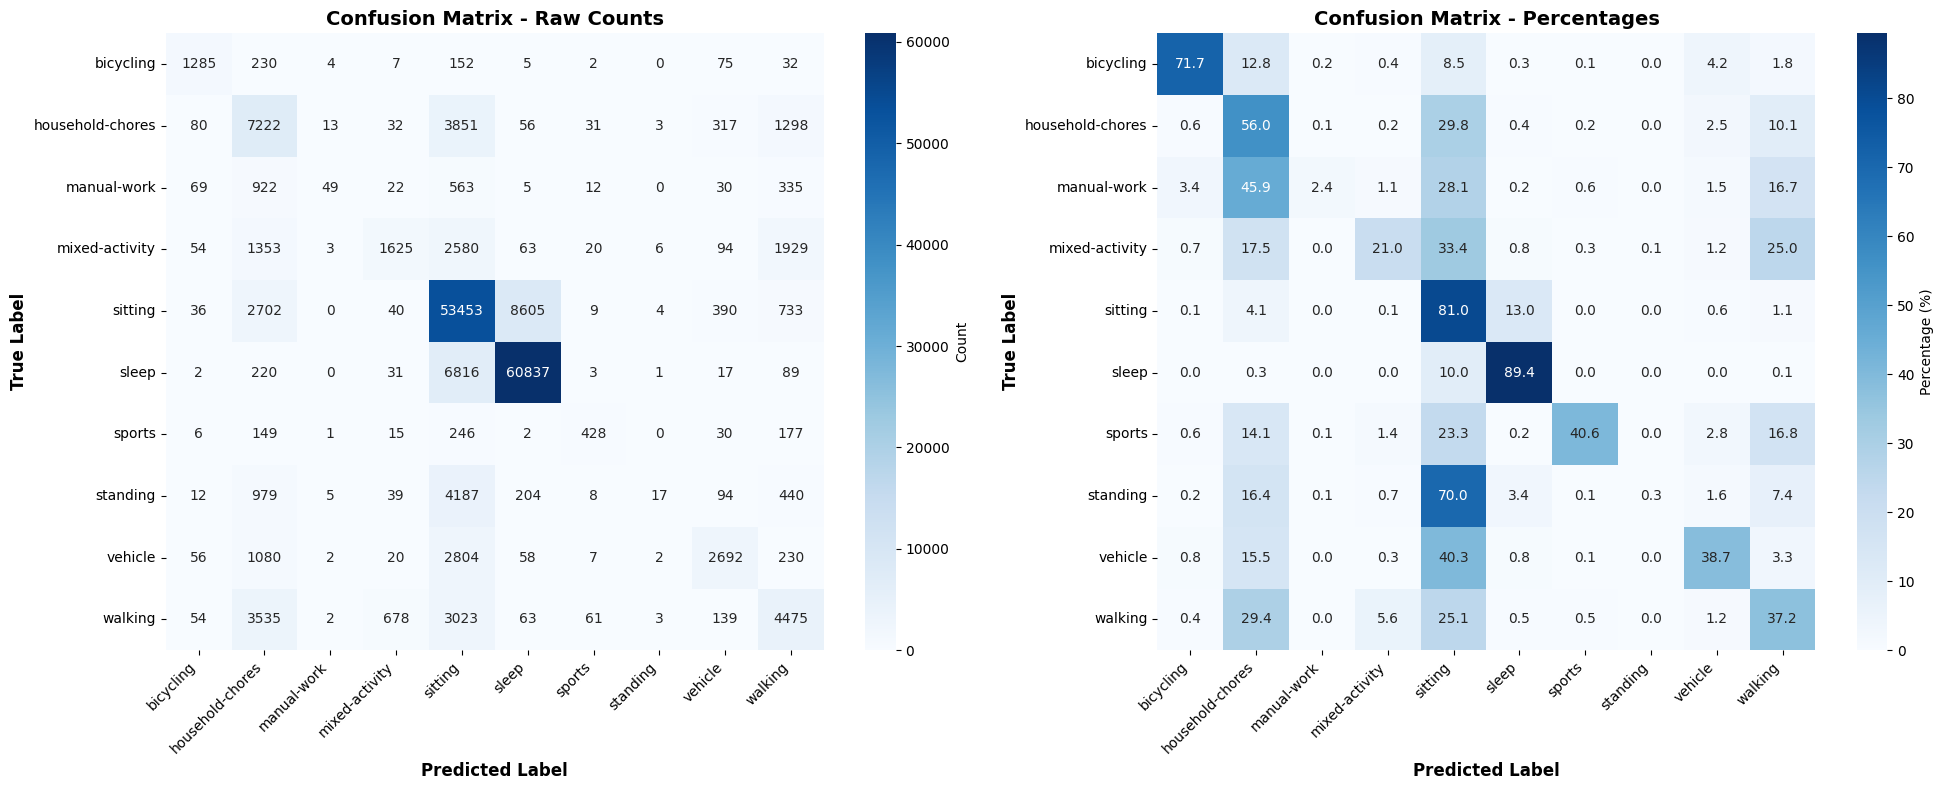

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')




valid_indices = Y != 'nan'
X_features_clean = X_features[valid_indices]
Y_clean = Y[valid_indices]
Y_encoded = label_encoder.transform(Y_clean)


X_train, X_test, y_train, y_test = train_test_split(
    X_features_clean, Y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=Y_encoded
)


y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')

# Plot 2
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'}, ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix - Percentages', fontsize=14, fontweight='bold')

# Rotate labels for readability
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Dataset shape: (922199, 33)
Activities: ['sleep' 'household-chores' 'walking' 'vehicle' 'standing'
 'mixed-activity' 'sitting' 'bicycling' 'sports' 'manual-work']

Class distribution:
activity
sleep               340080
sitting             329860
household-chores     64512
walking              60164
mixed-activity       38632
vehicle              34756
standing             29926
manual-work          10036
bicycling             8962
sports                5271
Name: count, dtype: int64

1. Analyzing feature distributions...


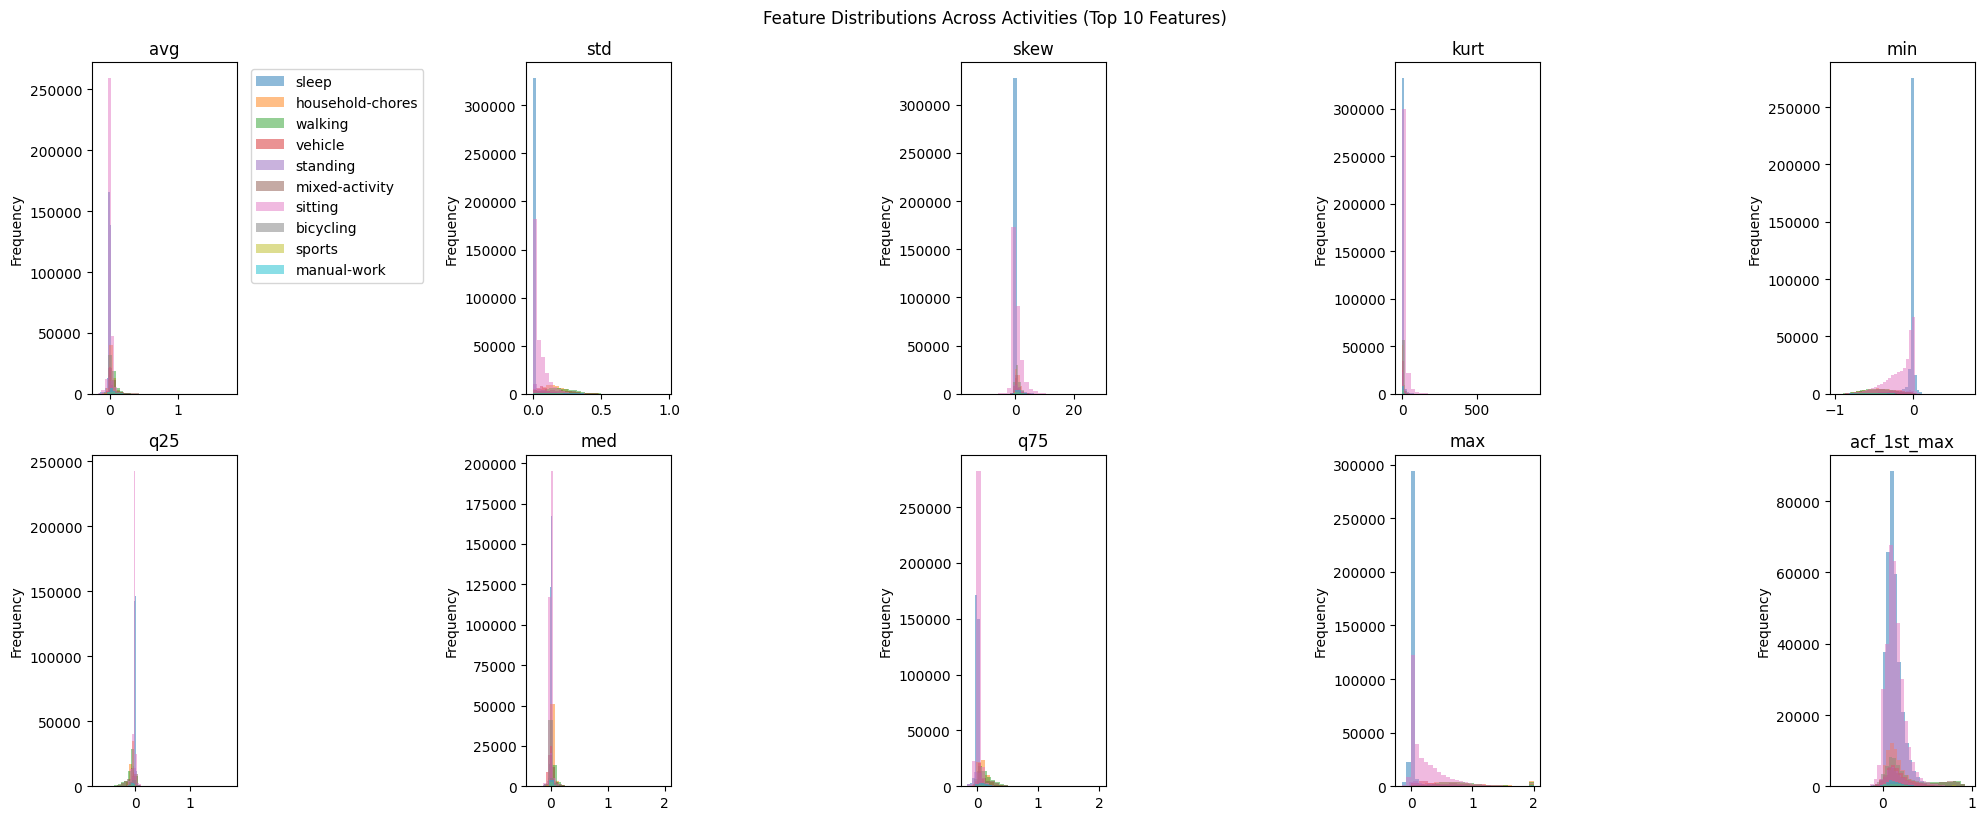

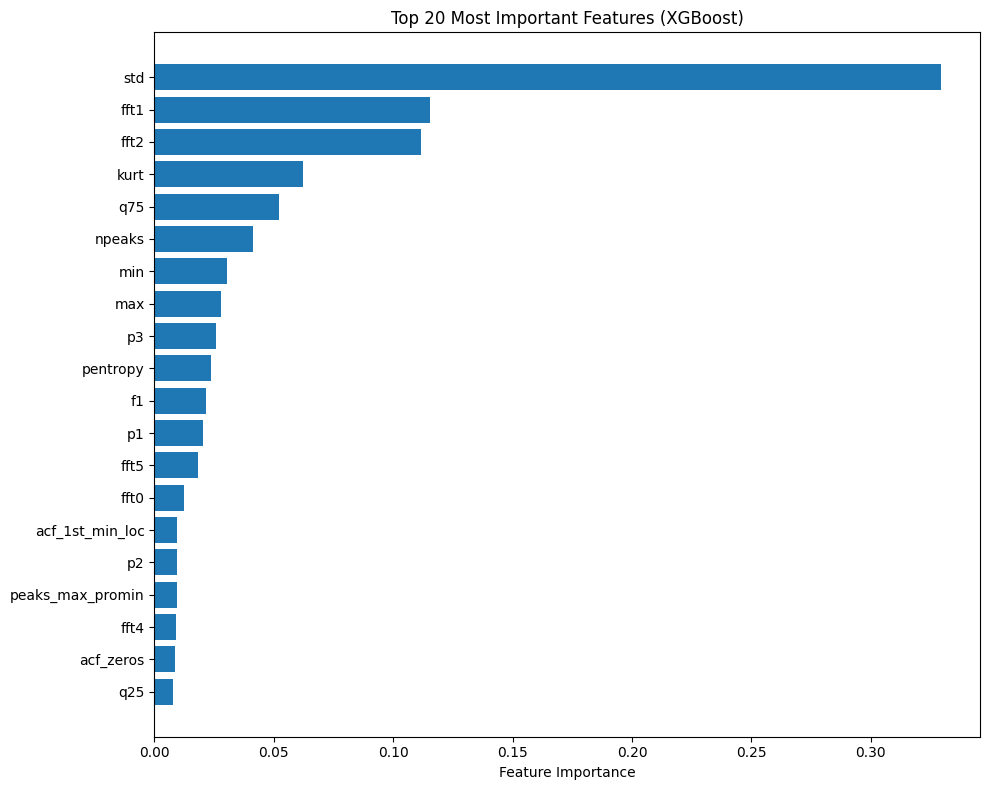


Top 10 most important features:
     feature  importance
1        std    0.329214
23      fft1    0.115573
24      fft2    0.111829
3       kurt    0.062426
7        q75    0.052236
28    npeaks    0.041150
4        min    0.030536
8        max    0.028032
21        p3    0.025710
14  pentropy    0.023771


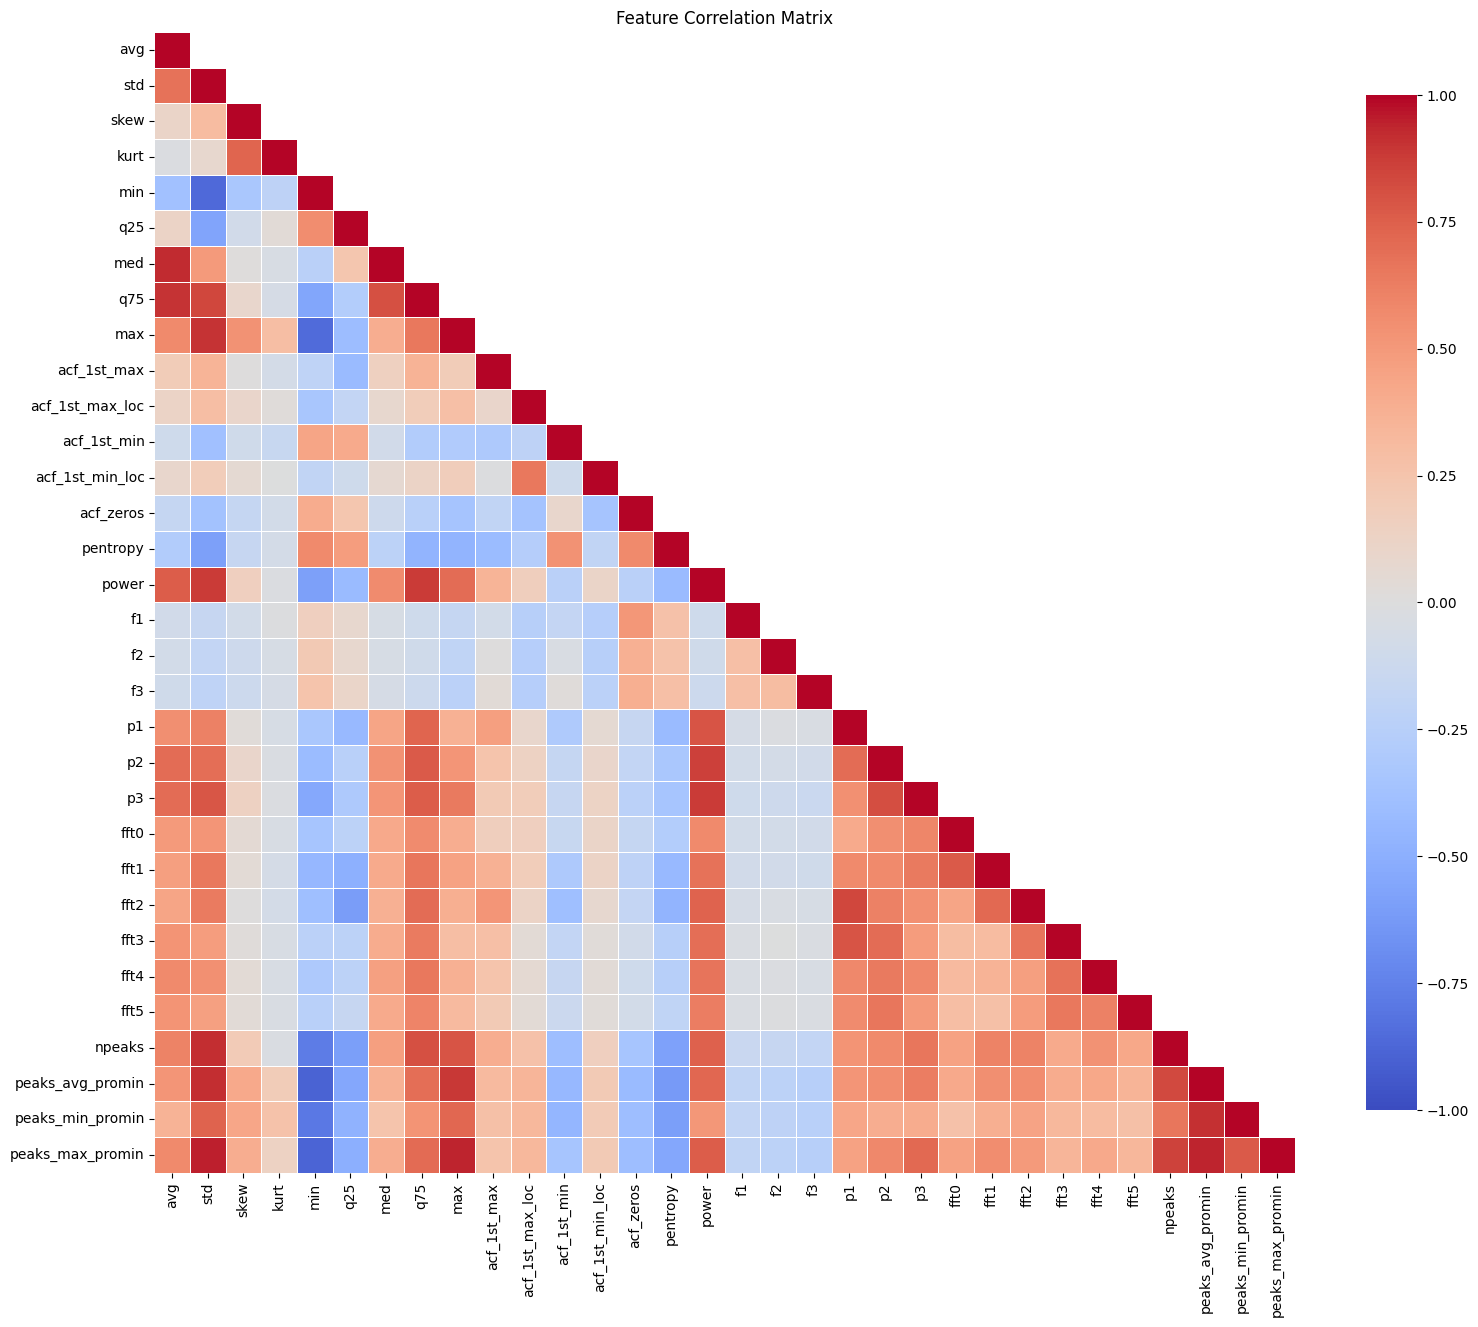


Highly Correlated Feature Pairs (|correlation| > 0.8):
  avg <-> med: 0.924
  avg <-> q75: 0.904
  std <-> min: -0.861
  std <-> q75: 0.839
  std <-> max: 0.904
  std <-> power: 0.878
  std <-> npeaks: 0.918
  std <-> peaks_avg_promin: 0.919
  std <-> peaks_max_promin: 0.948
  min <-> max: -0.859
  min <-> peaks_avg_promin: -0.891
  min <-> peaks_max_promin: -0.884
  med <-> q75: 0.810
  q75 <-> power: 0.877
  q75 <-> npeaks: 0.805
  max <-> peaks_avg_promin: 0.883
  max <-> peaks_max_promin: 0.939
  power <-> p2: 0.860
  power <-> p3: 0.876
  p1 <-> fft2: 0.840
  p2 <-> p3: 0.820
  npeaks <-> peaks_avg_promin: 0.829
  npeaks <-> peaks_max_promin: 0.858
  peaks_avg_promin <-> peaks_min_promin: 0.914
  peaks_avg_promin <-> peaks_max_promin: 0.944


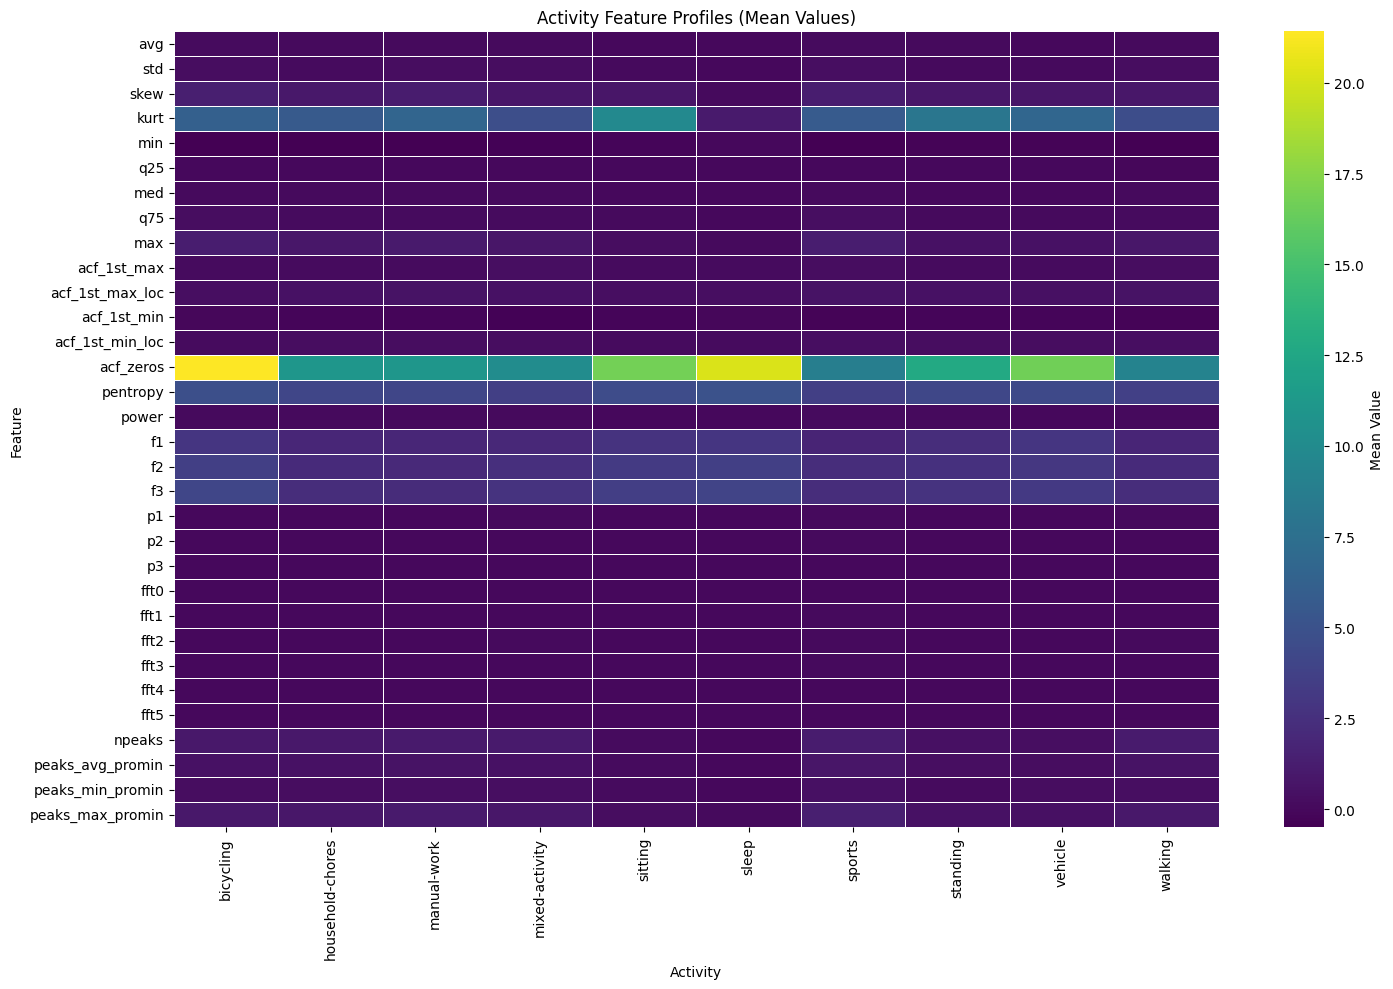

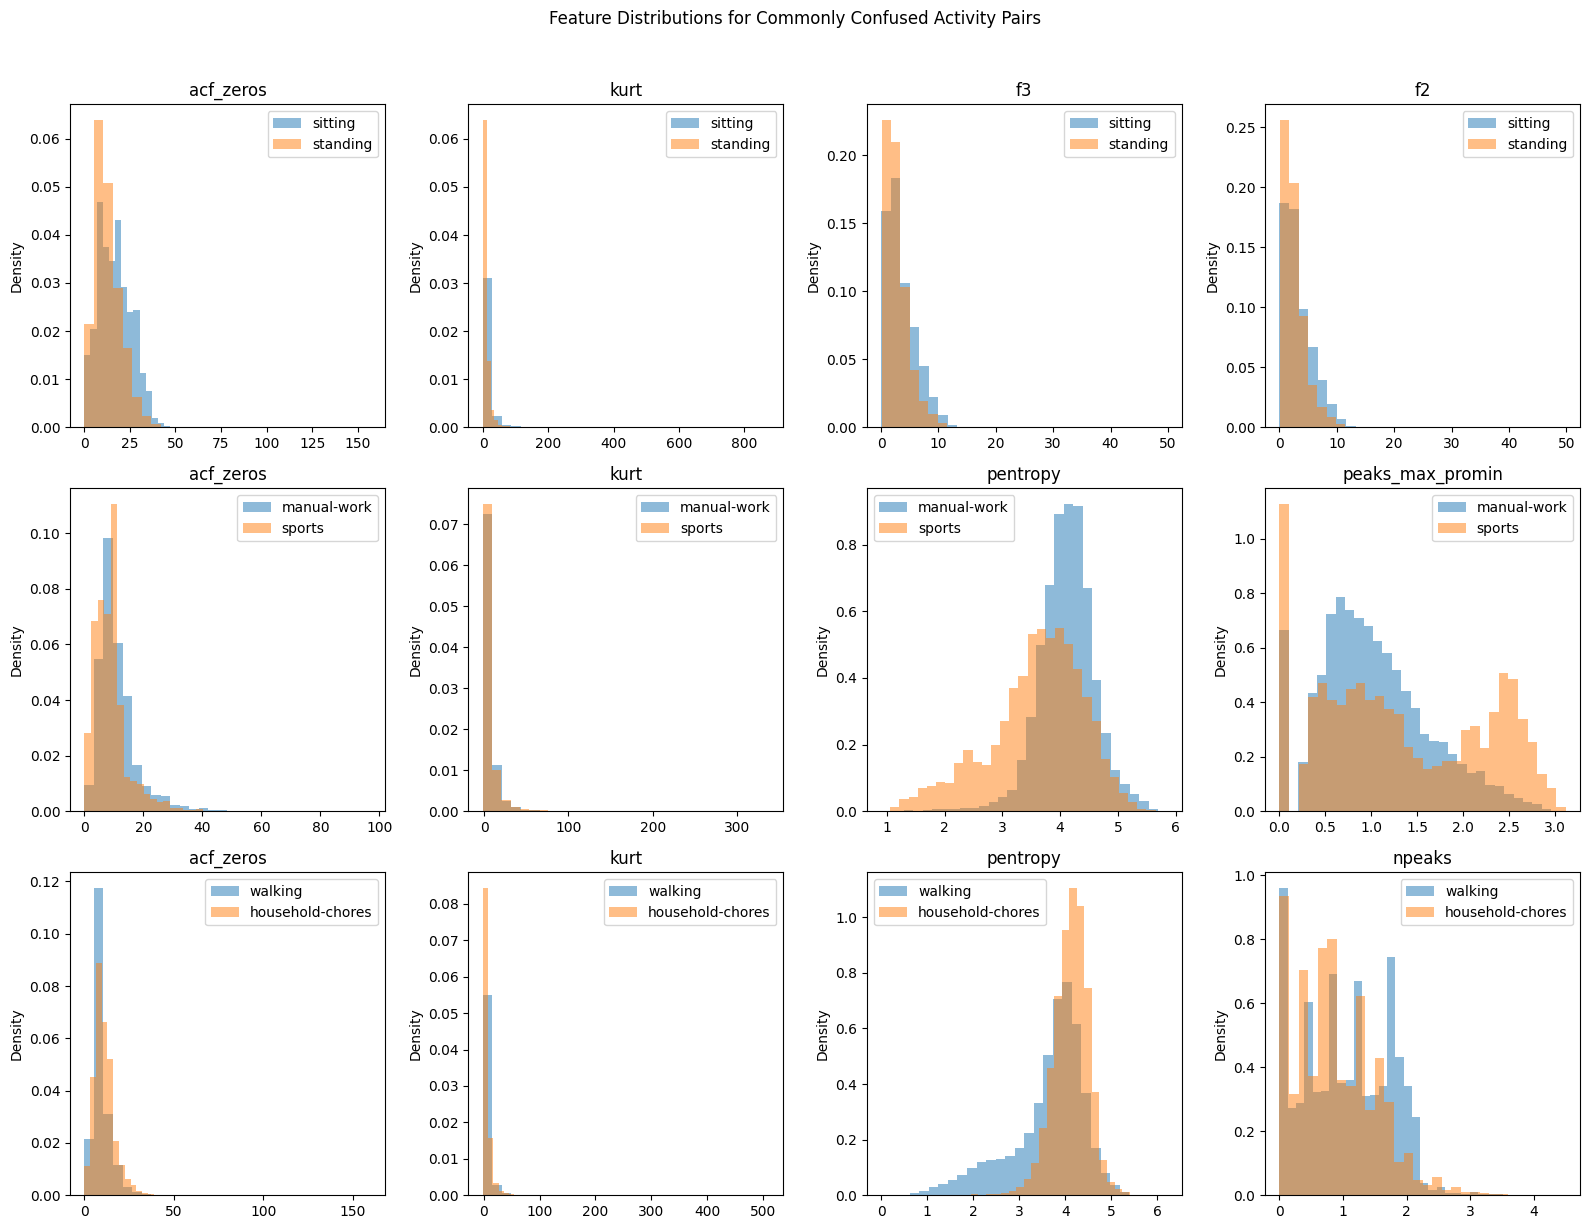

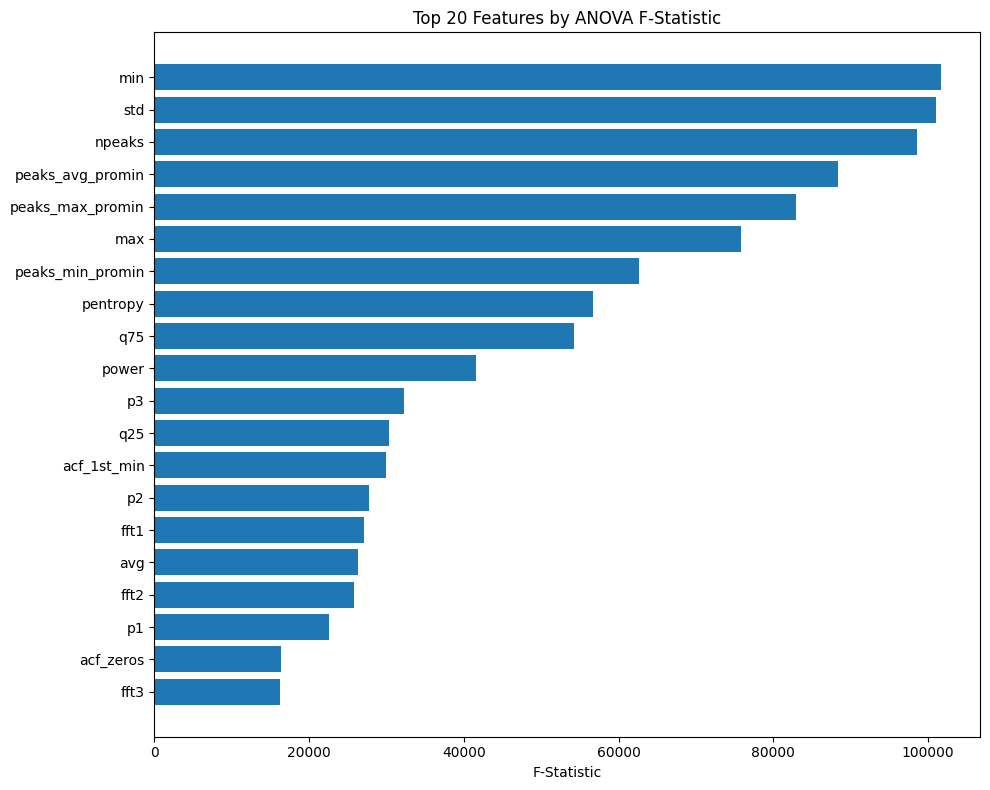


Top 10 discriminative features (by ANOVA):
             feature    f_statistic  p_value
4                min  101634.179688      0.0
1                std  101080.578125      0.0
28            npeaks   98633.765625      0.0
29  peaks_avg_promin   88426.031250      0.0
31  peaks_max_promin   82895.992188      0.0
8                max   75789.929688      0.0
30  peaks_min_promin   62596.027344      0.0
14          pentropy   56671.429688      0.0
7                q75   54225.378906      0.0
15             power   41561.738281      0.0


Top 15 features by importance with statistics:
            feature  importance    f_statistic  cv_across_activities
1               std    0.329214  101080.578125              0.619430
23             fft1    0.115573   27070.074219              0.979129
24             fft2    0.111829   25808.820312              1.260934
3              kurt    0.062426    9073.084961              0.394297
7               q75    0.052236   54225.378906              0.86814

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os



# 1. Create DataFrame with features and labels
feature_names = np.load(os.path.join('preprocessed', 'feature_names.npy'), allow_pickle=True)
valid_indices = Y != 'nan'
X_features_clean = X_features[valid_indices]
Y_clean = Y[valid_indices]

df = pd.DataFrame(X_features_clean, columns=feature_names)
df['activity'] = Y_clean

print(f"Dataset shape: {df.shape}")
print(f"Activities: {df['activity'].unique()}")
print(f"\nClass distribution:\n{df['activity'].value_counts()}")

# 2. Feature Distribution Analysis
def analyze_feature_distributions(df, feature_names, top_n=10):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    for idx, feature in enumerate(feature_names[:10]):
        ax = axes[idx]
        for activity in df['activity'].unique():
            activity_data = df[df['activity'] == activity][feature]
            ax.hist(activity_data, alpha=0.5, label=activity, bins=30)
        ax.set_title(feature)
        ax.set_ylabel('Frequency')
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.suptitle('Feature Distributions Across Activities (Top 10 Features)', y=1.02)
    plt.show()

print("\n1. Analyzing feature distributions...")
analyze_feature_distributions(df, feature_names)

# 3. Feature Importance from existing model
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10))

# 4. Correlation Analysis
correlation_matrix = df[feature_names].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((feature_names[i], feature_names[j], correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.8):")
    for f1, f2, corr in high_corr_pairs:
        print(f"  {f1} <-> {f2}: {corr:.3f}")

# 5. Activity-Specific Feature Profiles
profiles = df.groupby('activity')[feature_names].mean()

plt.figure(figsize=(15, 10))
sns.heatmap(profiles.T, cmap='viridis', cbar_kws={'label': 'Mean Value'},
            linewidths=0.5)
plt.xlabel('Activity')
plt.ylabel('Feature')
plt.title('Activity Feature Profiles (Mean Values)')
plt.tight_layout()
plt.show()

# 6. Analyze Confused Pairs
confused_pairs = [('sitting', 'standing'), ('manual-work', 'sports'), ('walking', 'household-chores')]

fig, axes = plt.subplots(len(confused_pairs), 4, figsize=(16, 12))

for pair_idx, (act1, act2) in enumerate(confused_pairs):
    if act1 in df['activity'].values and act2 in df['activity'].values:
        data1 = df[df['activity'] == act1][feature_names].mean()
        data2 = df[df['activity'] == act2][feature_names].mean()
        
        diff = abs(data1 - data2)
        top_diff_features = diff.nlargest(4).index
        
        for feat_idx, feature in enumerate(top_diff_features):
            ax = axes[pair_idx, feat_idx]
            
            val1 = df[df['activity'] == act1][feature].values
            val2 = df[df['activity'] == act2][feature].values
            
            ax.hist(val1, alpha=0.5, label=act1, bins=30, density=True)
            ax.hist(val2, alpha=0.5, label=act2, bins=30, density=True)
            ax.set_title(f'{feature}')
            ax.legend()
            ax.set_ylabel('Density')

plt.suptitle('Feature Distributions for Commonly Confused Activity Pairs', y=1.02)
plt.tight_layout()
plt.show()

# 7. ANOVA Analysis
anova_results = []

for feature in feature_names:
    groups = [group[feature].values for name, group in df.groupby('activity')]
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results.append({
        'feature': feature,
        'f_statistic': f_stat,
        'p_value': p_value
    })

anova_df = pd.DataFrame(anova_results).sort_values('f_statistic', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(anova_df['feature'][:20], anova_df['f_statistic'][:20])
plt.xlabel('F-Statistic')
plt.title('Top 20 Features by ANOVA F-Statistic')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 discriminative features (by ANOVA):")
print(anova_df.head(10))

# 8. Comprehensive Summary
summary = pd.DataFrame({'feature': feature_names})

for activity in df['activity'].unique():
    activity_data = df[df['activity'] == activity][feature_names]
    summary[f'{activity}_mean'] = activity_data.mean().values

summary = summary.merge(importance_df, on='feature')
summary = summary.merge(anova_df[['feature', 'f_statistic']], on='feature')

mean_cols = [col for col in summary.columns if '_mean' in col]
summary['cv_across_activities'] = summary[mean_cols].std(axis=1) / (summary[mean_cols].mean(axis=1) + 1e-10)

summary = summary.sort_values('importance', ascending=False)

print("\n\nTop 15 features by importance with statistics:")
print(summary[['feature', 'importance', 'f_statistic', 'cv_across_activities']].head(15))

summary.to_csv('feature_analysis_summary.csv', index=False)
print("\nSummary saved to 'feature_analysis_summary.csv'")

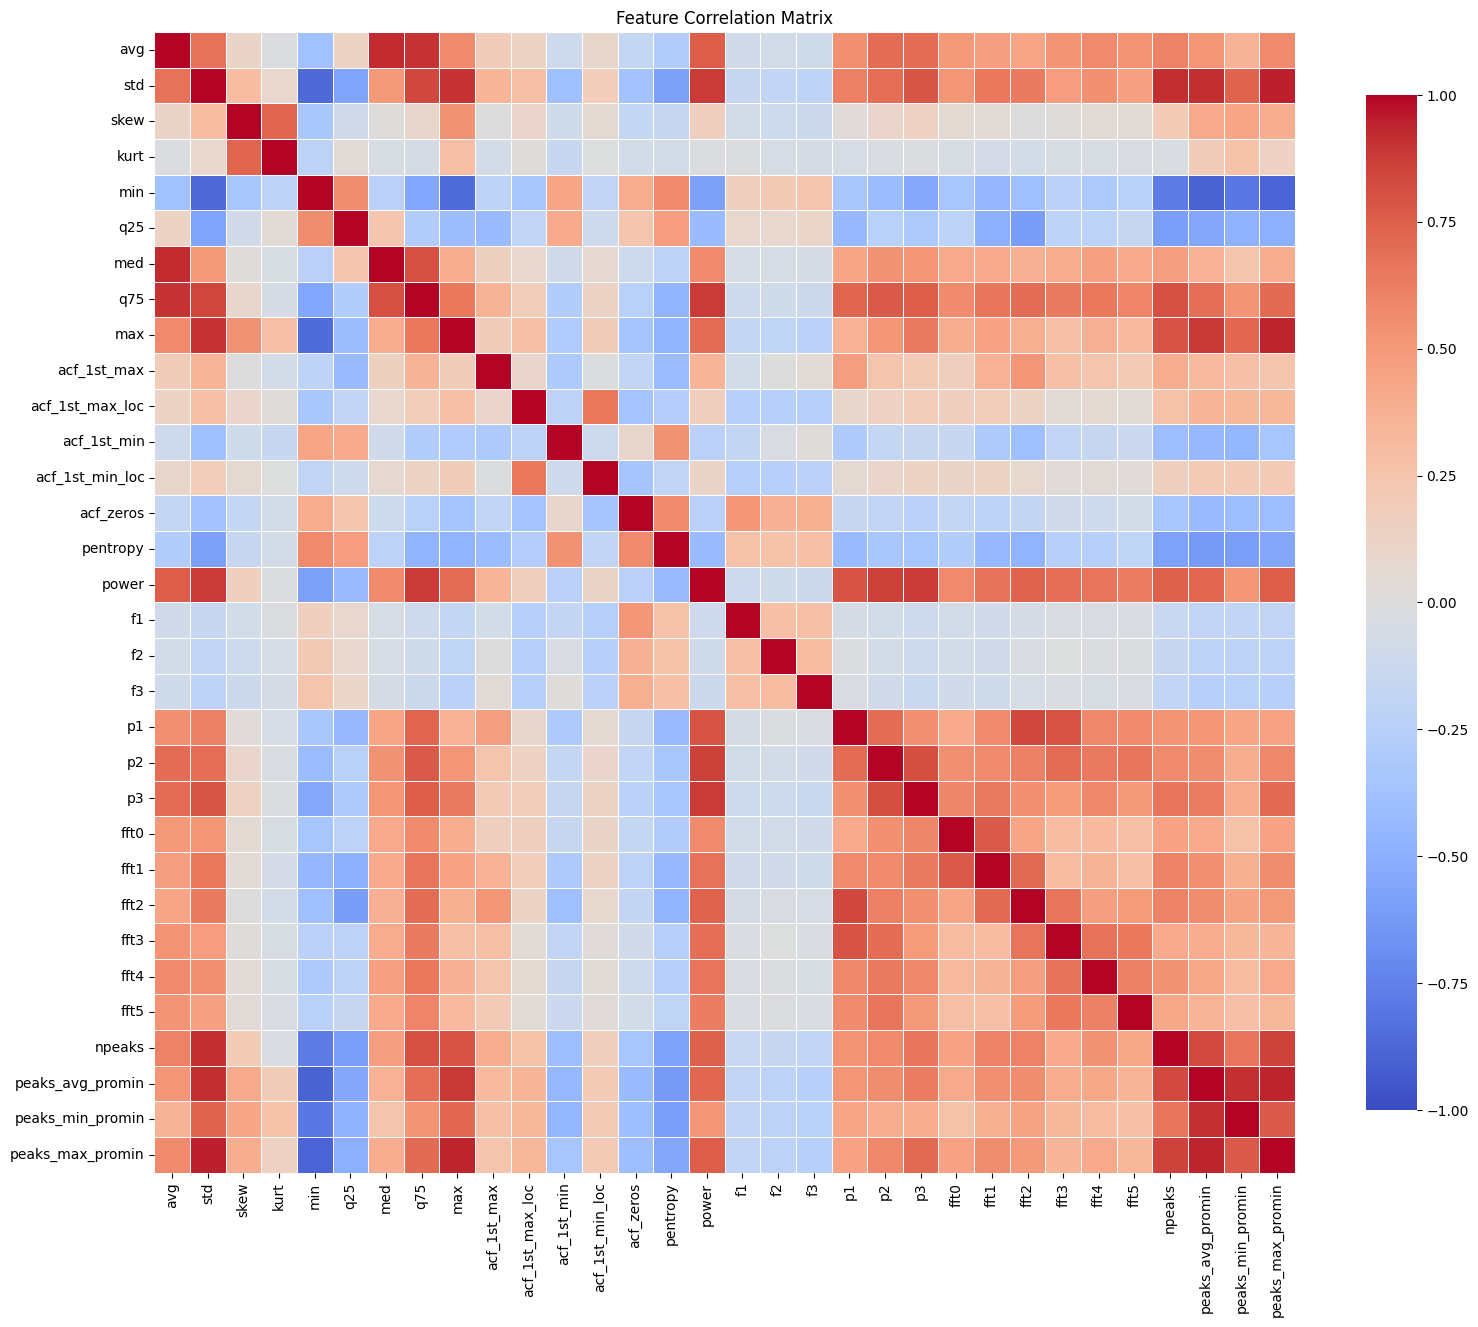

In [6]:
plt.figure(figsize=(16, 14))

sns.heatmap(correlation_matrix,cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

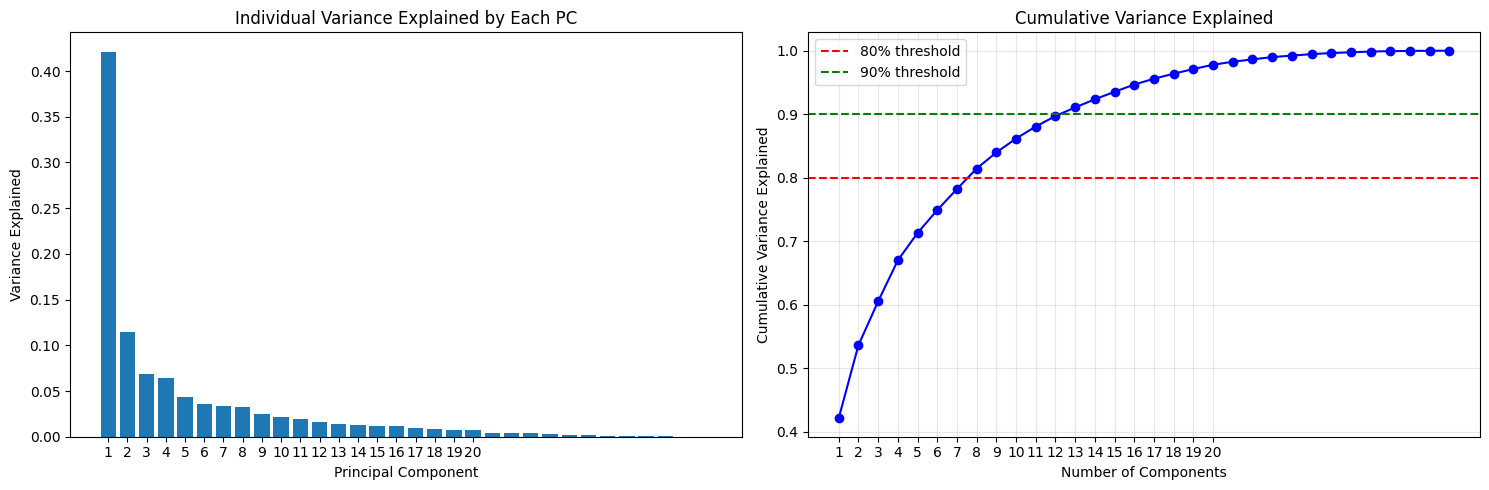

Components needed for 80% variance: 8
Components needed for 90% variance: 13
Variance explained by first 3 PCs: 60.53%


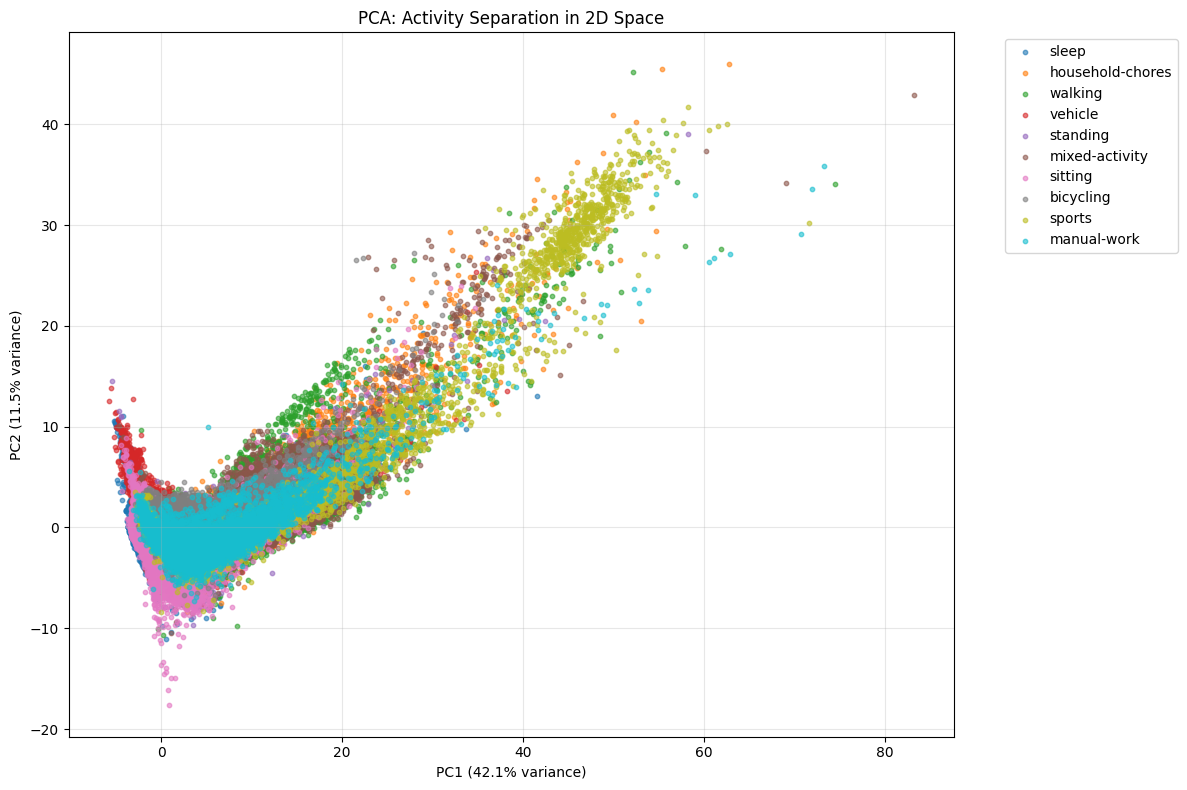

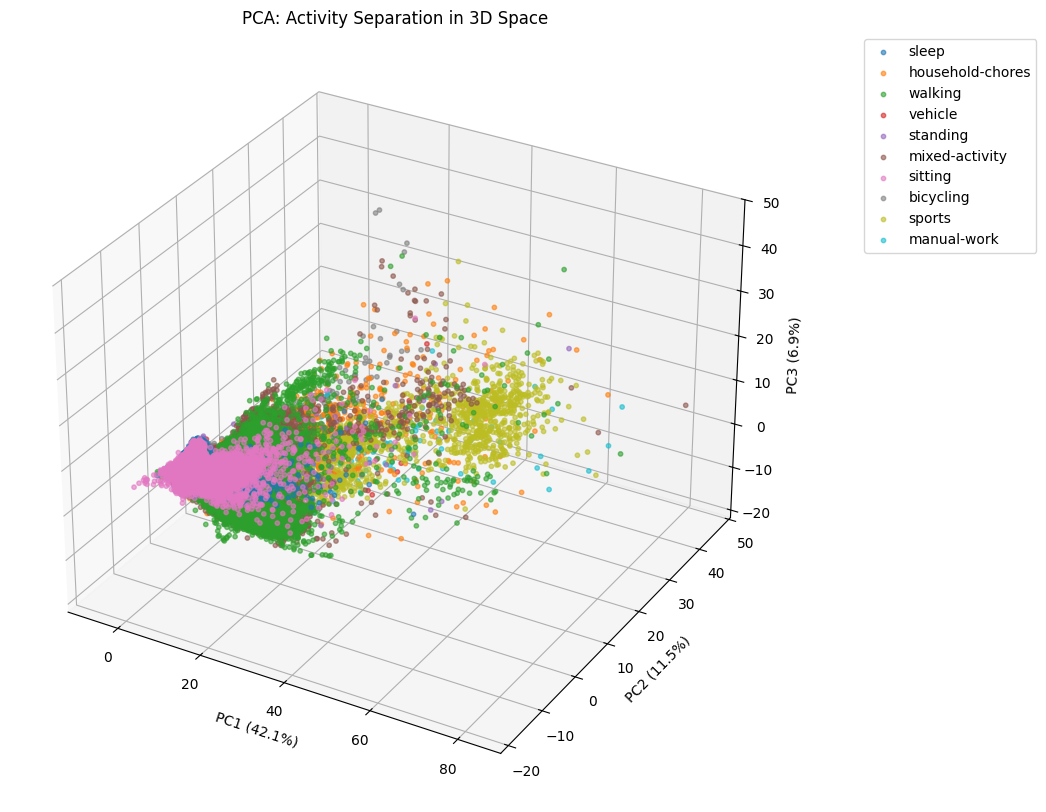

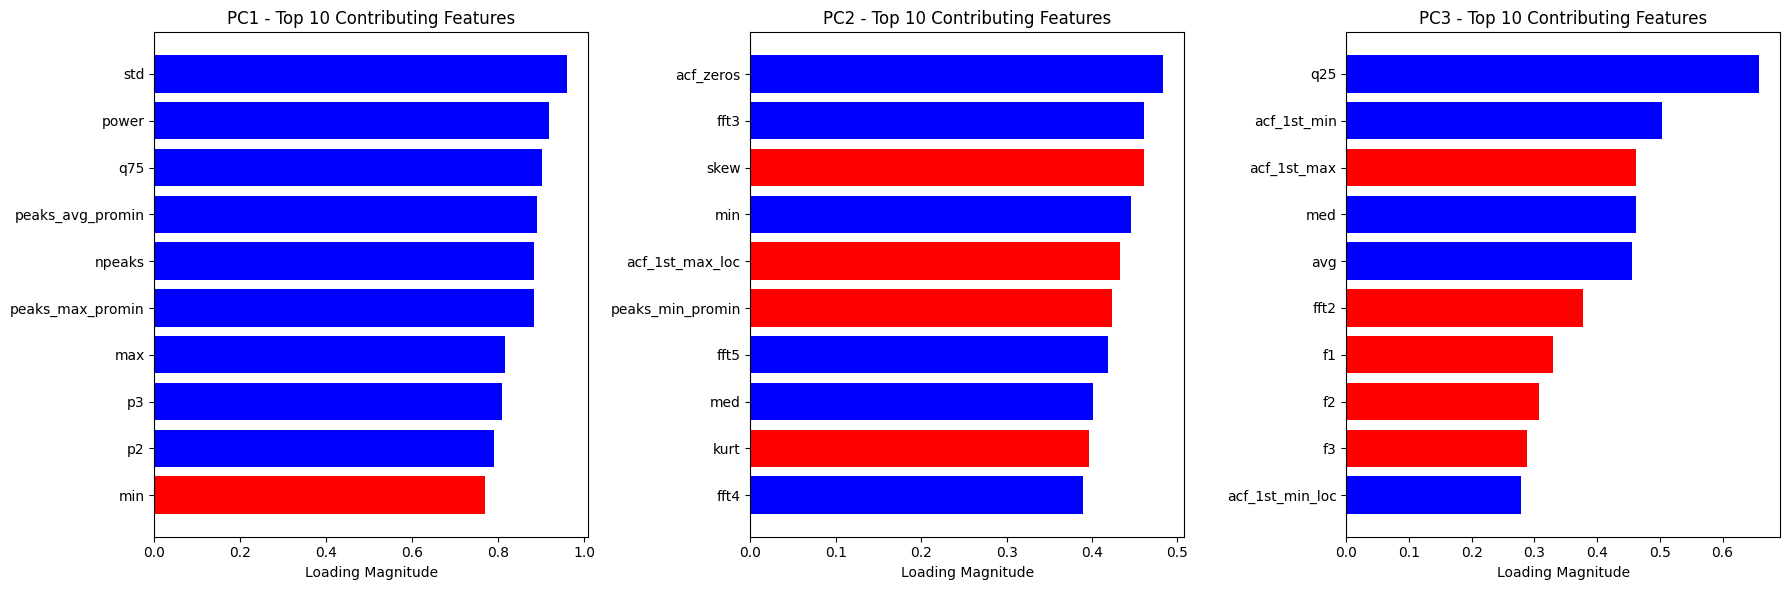


Top 5 features for each principal component:

PC1:
  std: 0.961
  power: 0.919
  q75: 0.902
  peaks_avg_promin: 0.890
  npeaks: 0.883

PC2:
  acf_zeros: 0.483
  fft3: 0.461
  skew: -0.461
  min: 0.446
  acf_1st_max_loc: -0.433

PC3:
  q25: 0.659
  acf_1st_min: 0.504
  acf_1st_max: -0.462
  med: 0.462
  avg: 0.456


Cluster separation analysis (centroid distances in PC1-PC2 space):
  sitting <-> standing: 1.66
  manual-work <-> sports: 8.80
  walking <-> household-chores: 1.52
  sitting <-> sleep: 1.66


Activity spread in PCA space (std dev of first 2 PCs):
  sleep               : PC1_std=0.85, PC2_std=1.01
  household-chores    : PC1_std=3.85, PC2_std=2.04
  walking             : PC1_std=4.78, PC2_std=2.14
  vehicle             : PC1_std=2.36, PC2_std=1.80
  standing            : PC1_std=3.01, PC2_std=1.63
  mixed-activity      : PC1_std=5.31, PC2_std=2.45
  sitting             : PC1_std=1.85, PC2_std=1.61
  bicycling           : PC1_std=4.14, PC2_std=2.21
  sports              : PC1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Using existing variables: df, feature_names from previous analysis

# Prepare data for PCA
X_for_pca = df[feature_names].values
y_activities = df['activity'].values

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_pca)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 1. Variance Explained Analysis
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(range(1, len(variance_explained) + 1), variance_explained)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Individual Variance Explained by Each PC')
axes[0].set_xticks(range(1, min(21, len(variance_explained) + 1)))

axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.9, color='g', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, min(21, len(cumulative_variance) + 1)))

plt.tight_layout()
plt.show()

n_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Components needed for 80% variance: {n_80}")
print(f"Components needed for 90% variance: {n_90}")
print(f"Variance explained by first 3 PCs: {cumulative_variance[2]:.2%}")

# 2. 2D PCA Visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

activities = df['activity'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(activities)))

for activity, color in zip(activities, colors):
    mask = y_activities == activity
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[color], label=activity, alpha=0.6, s=10)

ax.set_xlabel(f'PC1 ({variance_explained[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({variance_explained[1]:.1%} variance)')
ax.set_title('PCA: Activity Separation in 2D Space')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. 3D PCA Visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for activity, color in zip(activities, colors):
    mask = y_activities == activity
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
               c=[color], label=activity, alpha=0.6, s=10)

ax.set_xlabel(f'PC1 ({variance_explained[0]:.1%})')
ax.set_ylabel(f'PC2 ({variance_explained[1]:.1%})')
ax.set_zlabel(f'PC3 ({variance_explained[2]:.1%})')
ax.set_title('PCA: Activity Separation in 3D Space')
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.show()

# 4. Loading Analysis - Which features contribute to each PC
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(
    loadings[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_names
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    top_features = loading_df[pc].abs().nlargest(10)
    colors = ['red' if loading_df.loc[feat, pc] < 0 else 'blue' for feat in top_features.index]
    
    axes[i].barh(range(len(top_features)), top_features.values, color=colors)
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels(top_features.index)
    axes[i].set_xlabel('Loading Magnitude')
    axes[i].set_title(f'{pc} - Top 10 Contributing Features')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 features for each principal component:")
for pc in ['PC1', 'PC2', 'PC3']:
    print(f"\n{pc}:")
    top_5 = loading_df[pc].abs().nlargest(5)
    for feat in top_5.index:
        print(f"  {feat}: {loading_df.loc[feat, pc]:.3f}")

# 5. Analyze Overlapping Activities
def analyze_cluster_overlap(X_pca, y_activities, act1, act2):
    mask1 = y_activities == act1
    mask2 = y_activities == act2
    
    if mask1.sum() == 0 or mask2.sum() == 0:
        return None
    
    pc1_1, pc2_1 = X_pca[mask1, 0], X_pca[mask1, 1]
    pc1_2, pc2_2 = X_pca[mask2, 0], X_pca[mask2, 1]
    
    centroid1 = (np.mean(pc1_1), np.mean(pc2_1))
    centroid2 = (np.mean(pc1_2), np.mean(pc2_2))
    
    distance = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
    
    return distance

print("\n\nCluster separation analysis (centroid distances in PC1-PC2 space):")
problem_pairs = [('sitting', 'standing'), ('manual-work', 'sports'), 
                 ('walking', 'household-chores'), ('sitting', 'sleep')]

for act1, act2 in problem_pairs:
    dist = analyze_cluster_overlap(X_pca, y_activities, act1, act2)
    if dist:
        print(f"  {act1} <-> {act2}: {dist:.2f}")

# 6. Activity-specific variance in PCA space
print("\n\nActivity spread in PCA space (std dev of first 2 PCs):")
for activity in activities:
    mask = y_activities == activity
    if mask.sum() > 0:
        std_pc1 = np.std(X_pca[mask, 0])
        std_pc2 = np.std(X_pca[mask, 1])
        print(f"  {activity:20s}: PC1_std={std_pc1:.2f}, PC2_std={std_pc2:.2f}")